Using Amazon SageMaker to Access AWS Redshift Tables Defined in AWS Glue Data Catalog
====================

This notebook demonstrates accessing Redshift datasets defined in the Glue Data Catalog data from a SageMaker notebook. 

Access occurs via:
* a Sparkmagic (https://github.com/jupyter-incubator/sparkmagic) notebook (PySpark) 
* Apache Livy (https://livy.incubator.apache.org/), running on an EMR cluster
* The EMR cluster has the Redshift driver installed, and uses the Glue Data Catalog as its metastore
* Uses the EMR metastore to check datasets defined in a Glue Data Catalog
* Uses connection information retrieved from the Glue Data Catalog to access a Redshift cluster, from EMR
* Reads datasets from Redshift into EMR
* Returns the data from EMR as a dataframe for local access in the SageMaker Notebook.

In order to set this up, follow the instructions in the accompanying blog post, here [[TO DO - INSERT LINK TO BLOG POST ]]



## Table of Contents
1. [Set up access to the Glue Data Catalog](#emr_setup)
1. [Access Glue Data Catalog using SQL magics](#glue_access)   
1. [Access Redshift data](#redshift_access)
1. [Using the Data on the Local Notebook](#local_access)

## Set up Access to the Amazon Glue Data Catalog<a name='emr_setup'></a>

This Jupyter notebook is written to run on a SageMaker notebook instance. It uses SparkMagic (PySpark) to access Apache Spark, running on Amazon EMR. 

The EMR cluster runs Spark and Apache Livy, and must be set up to use the AWS Glue Data Store for its Hive metastore.

In addition, the SageMaker notebook instance must be configured to access Livy.

This configuration is established in the accompanying blog post [[UPDATE WITH NAME AND LINK]].


Now:
* Check that this notebook is using SparkMagic (PySpark) (look in the top right corner).
* Restarted the kernel of this notebook (Kernel -> Restart -> Restart).
* If you've left the notebook for some time, also restart the kernel and re-execute the cells. This is because the Livy connection times out.

Then, print out the list of Livy magic commands.

In [1]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.


The following cell prints out info about the current Spark sessions.  

In [13]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1606801604877_0001,pyspark,idle,Link,Link,✔


There may be "no active sessions" so far. If so, that's ok, you'll start one below. If you or someone else has run other sessions recently, you may receive a list of existing sessions.   

If you receive an error such as "Error sending http request and maximum retry encountered", try restarting the kernel, then re-executing these cells. 

If you continue to see an error, check the configuration. Use a terminal to check that .sparkmagic/config.json on this SageMaker notebook instance has the correct IP address and port for the EMR cluster. Check that the EMR cluster has started correctly. Check that the EMR cluster's port is open and accessible to the SageMaker instance. Try accessing your EMR cluster on the Livy port (default 8998); you should see the Livy welcome page. Remember to restart the kernel after every change!

Once this cell executes correctly, move on! 

The next cell should start a Spark session, and an application if needed. 

It'll also print out the IP address of the EMR cluster's master, and current setting of environment variables. 

In [14]:
import os
import platform
# Print some characteristics of the remote system
print(platform.node())
print(platform.platform(aliased=0, terse=0))
print("Spark home currently set to", os.environ.get('SPARK_HOME', None))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ip-172-31-32-197
Linux-4.14.104-78.84.amzn1.x86_64-x86_64-with-glibc2.2.5
('Spark home currently set to', '/usr/lib/spark')

After running the previous cell (it may take a minute or three to complete), you should see a message "SparkSession available as 'spark'." 

If you don't: restart the Kernel for this notebook, and try running the above cells again.

Now, run a basic Spark function. This cell shows how you can execute Spark parallelized functions on your EMR cluster.

In [15]:
# Run a basic Spark function, to show that's working
# NOTE: This cell will likely throw an error the first time you run it ('TypeError: object of type 'NoneType' has no len()'). 
# This is due to a bug that showed up after 2.3.1 -> 2.3.2 upgrade of Spark.
# It's also reported here: http://mail-archives.apache.org/mod_mbox/spark-issues/201811.mbox/%3CJIRA.13197858.1542041679000.391200.1542675600612@Atlassian.JIRA%3E
# and here: http://mail-archives.apache.org/mod_mbox/livy-issues/201811.mbox/<JIRA.13199283.1542622344000.385221.1542622380848@Atlassian.JIRA>
print("Spark version is: " + sc.version)
sc.parallelize(range(1000)).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Spark version is: 2.4.0
1000

In [16]:
# Run a basic Spark function, to show that's working (and this time, it really should!)
print("Spark version is: " + sc.version)
sc.parallelize(range(1000)).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Spark version is: 2.4.0
1000

Now, you can see the logs from this Spark task. This capability allows us to debug our Spark tasks without leaving the notebook environment.

In [17]:
%%logs

stdout: 

stderr: 
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$updateAccumulators$1.apply(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$updateAccumulators$1.apply(DAGScheduler.scala:1286)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.updateAccumulators(DAGScheduler.scala:1286)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:1376)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2257)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2209)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2198)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
20/12/01 11:50:39 ERROR DAGScheduler: Failed to update accumulator 0 (org.apache.spa

## Access Glue Data Catalog<a name='glue_access'></a> 

Let's switch to the topic at hand. 

The following examples run against the Glue 'glueredsage' database (or, the Glue database name you gave when executing the CloudFormation template). 
If you have not already done so, follow the instructions in the Glue tutorial under “Crawling the Sample Data Used in the Tutorials” (https://docs.aws.amazon.com/glue/latest/dg/dev-endpoint-tutorial-prerequisites.html#dev-endpoint-tutorial-prerequisites-crawl-data ), as outlined in the blog post instructions. You can stop once you’ve completed the steps to create the crawler, and can see the tables created by the crawler in your Data Catalog, containing metadata that the crawler retrieved.

First, list the databases in the Glue Data Catalog. Then, list the tables, and the columns for the table you're interested in.

In [18]:
%%local
######################################################################################################
# Update/Check the following variables with values for your environment
# -- should have been correctly updated by the CF stack during deployment
######################################################################################################

glueDatabase = "irisred"
region = "us-west-2"

In [19]:
%%local
!aws glue get-databases --output text | grep glueredsage

Set up a couple of helper functions that will call the Glue Data Catalog, and format the most relevant parts of the response for this task.

In [20]:
%%local
import boto3

# Helper functions, to retrieve Glue Data Catalog information
glue = boto3.client('glue', region_name=region)

# List the tables in the given Glue database
def get_glue_tables(gluedatabase):
	# From Glue/Hive metastore, get the table info.
	tbls = glue.get_tables(DatabaseName=gluedatabase)
	i = 0
	print('{:5s} {:20s} {:30s}  {:20}'.format('', 'Database', 'TableName', 'TableType'))
	for tbl in tbls['TableList']:
		print('{:5s} {:20s} {:30s}  {:20}'.format(str(i), gluedatabase, tbl['Name'], tbl['TableType']))
		i += 1

# List the columns of the named Glue table    
def get_glue_table(gluedatabase, gluetblnm):
	# From Glue/Hive metastore, get the table info.
	tbldef = glue.get_table(DatabaseName=gluedatabase, Name=gluetblnm)
	print('Table: ' + gluedatabase + '.' + gluetblnm + ': ' + tbldef['Table']['TableType'])
	if 'classification' in tbldef['Table']['Parameters'] and 'connectionName' in tbldef['Table']['Parameters']:
		print('Classification: ' + tbldef['Table']['Parameters']['classification'] + '; connectionName: ' + tbldef['Table']['Parameters']['connectionName'])
	else:
		print('Classification / connection information not available.')
	i = 0
	print('{:5s} {:20s} {:20s} {:50s}'.format('','Column Name', 'Type', 'Comment'))
	for col in tbldef['Table']['StorageDescriptor']['Columns']:
		comment = ''
		if 'Comment' in col:
			comment = col['Comment']    
		print('{:5s} {:20s} {:20s} {:50s}'.format(str(i), col['Name'], col['Type'], comment))
		i += 1


Call the first helper function, to list the tables in the Glue database you're interested in.

In [21]:
%%local
get_glue_tables(glueDatabase)

      Database             TableName                       TableType           
0     irisred              dev_public_category             EXTERNAL_TABLE      
1     irisred              dev_public_date                 EXTERNAL_TABLE      
2     irisred              dev_public_event                EXTERNAL_TABLE      
3     irisred              dev_public_listing              EXTERNAL_TABLE      
4     irisred              dev_public_sales                EXTERNAL_TABLE      
5     irisred              dev_public_users                EXTERNAL_TABLE      
6     irisred              dev_public_venue                EXTERNAL_TABLE      


If you do not receive a list of the Redshift tables from the above command, check that you've run the Glue-Redshift crawler. Use the AWS Glue console to check that there are, in fact, tables in that database.

For a chosen table, list the columns.

In [22]:
%%local
tblnme = 'dev_public_category'
get_glue_table(glueDatabase, tblnme)

Table: irisred.dev_public_category: EXTERNAL_TABLE
Classification: redshift; connectionName: rs-glue
      Column Name          Type                 Comment                                           
0     catid                smallint                                                               
1     catname              string                                                                 
2     catdesc              string                                                                 
3     catgroup             string                                                                 


You can see that this table has a classification of "redshift", and it's connection (GlueRedshiftConnection). So, to access the data, you'll need to read the data from Redshift. The GlueRedshiftConnection will contain the information you need to connect to Redshift.

## Access Redshift data<a name='redshift_access'></a> 


Now, you wish to retrieve a table (or, part of a table, or the results of a SQL query), for futher specialized processing. Generally speaking, you want to do as much as you can with the data in place, and only retrieve the subset of data you need to perform actions on that cannot be performed in SQL.  

If the data is small, you can retrieve directly into your notebook. But since this data is likely large, you'll retrieve it into a data frame in Spark on EMR so you can process it further there.

First, set up the variables on the remote cluster. Note that these variables are separate from those used in your local environment, and that the variables are not communicated between the two environments.

In [23]:
######################################################################################################
# Update/Check the following variables with values for your environment
# -- should have been correctly updated by the CF stack during deployment
######################################################################################################
# Redshift IAM Copy Role, attached to the Redshift cluster you're trying to access.
iamcopyrole = 'arn:aws:iam::029498593638:role/rs-cluster-RedshiftIamCopyRole-1PEZ76PIOEXKS'
glueDatabase = 'irisred'
# Tablename here is the Glue table
# NOTE that they can't have '-' in them; it's ok by Glue, but not for Hive
tblname = 'dev_public_category'
region = 'us-west-2'
s3Bucket = 'sagemakerworkshop-log-dsc-smlab'
# Temp directory; should have lifecycle policy to delete temp files 'frequently'. 
# Remember to use the format: 's3a://<bucket>/<prefix>/'
tempS3Dir = 's3a://' + s3Bucket + '/temp/'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Next, set up helper functions to retrieve Redshift connection information from the Glue Data Catalog, and to read the table from Redshift into EMR. 

In [24]:
import boto3
from pyspark.sql import SQLContext

sql_context = SQLContext(sc)

def get_redshift_connection_info(gluedatabase, gluetblname, awsregion):
	# From Glue/Hive metastore, get the table info.
	client = boto3.client('glue', region_name=awsregion)
	tbl = client.get_table(DatabaseName=gluedatabase, Name=gluetblname)
	parms = tbl['Table']['StorageDescriptor']['Parameters']
	classn = parms['classification']
	conn = parms['connectionName']
	location = tbl['Table']['StorageDescriptor']['Location']
	if classn <> 'redshift':
		print('This table is not a Redshift table; it is of type ' + str(classn))
		return None
	# THEN: Get connection data.
	response = client.get_connection(Name=conn)
	connp = response['Connection']['ConnectionProperties']
	url = connp['JDBC_CONNECTION_URL'] + '?user=' + connp['USERNAME'] + '&password=' + connp['PASSWORD']
	print('Connection info:', location, connp['JDBC_CONNECTION_URL'])
	return (url, location)

def get_redshift_data(gluedatabase, gluetblname, awsregion, tempS3Dir, iamcopyrole):
	(url, location) = get_redshift_connection_info(gluedatabase, gluetblname, awsregion)
	tblbits = location.split('.')
	rstblname = tblbits[1] + '.' + tblbits[2]    
	print('Getting dataframe:', gluetblname, '-->', rstblname)   
	# THEN finally, get the data.
	df = sql_context.read.format('com.databricks.spark.redshift').option('aws_iam_role',iamcopyrole).option('tempdir', tempS3Dir).option('url', url).option('dbtable', rstblname).load() 
	return df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Next, this code retrieves the table from Redshift to S3, then into EMR, and finally into a data frame that you can access locally. This is all done for you by the Spark Redshift driver you're using here.

The '-o' parameter gives the data frame name. You can take a subset or sample of the rows, using the Livy -r, -m and -n options described in the Help above. As it's a large dataset, here you'll first retrieve a small subset to review. (It may take a few minutes to retrieve the data.)

In [25]:
%%spark -o category -n 25

# This next command gets the table into the dataframe 'users', on the Spark cluster
category = get_redshift_data(glueDatabase, tblname, region, tempS3Dir, iamcopyrole)
category.show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

('Connection info:', u'dev.public.category', u'jdbc:redshift://rs-cluster-redshiftcluster-8gdu5k60mj60.cocm2vzetawj.us-west-2.redshift.amazonaws.com:5439/dev')
('Getting dataframe:', 'dev_public_category', '-->', u'public.category')
+-----+--------+---------+------------------------------------------+
|catid|catgroup|catname  |catdesc                                   |
+-----+--------+---------+------------------------------------------+
|1    |Sports  |MLB      |Major League Baseball                     |
|7    |Shows   |Plays    |All non-musical theatre                   |
|5    |Sports  |MLS      |Major League Soccer                       |
|9    |Concerts|Pop      |All rock and pop music concerts           |
|6    |Shows   |Musicals |Musical theatre                           |
|10   |Concerts|Jazz     |All jazz singers and bands                |
|3    |Sports  |NFL      |National Football League                  |
|8    |Shows   |Opera    |All opera and light opera                

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

You can also use a SQL to specify a subset of the data; or, to join, aggregate and filter data on the Redshift cluster. The helper function and small example below shows you how.

In [26]:
def get_redshift_query(url, tempS3Dir, sqlquery):
	df = sql_context.read.format('com.databricks.spark.redshift').option('tempdir', tempS3Dir).option('url', url).option('query', sqlquery).load()
	print('Getting dataframe:', sqlquery)    
	return df


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Alternately, you can add SQL statements, to join, filter or aggregate the Redshift data prior to unloading it.

In [27]:
%%spark -o userevents
# First, get the connection information for Redshift, using a table that's stored in that cluster
(url, tblbits) = get_redshift_connection_info(glueDatabase, tblname, region)

sqlquery = """SELECT distinct u.userid, u.city, u.state, 
NVL(u.likebroadway, false) as likebroadway, NVL(u.likeclassical, false) as likeclassical, NVL(u.likeconcerts, false) as likeconcerts, 
NVL(u.likejazz, false) as likejazz, NVL(u.likemusicals, false) as likemusicals, NVL(u.likeopera, false) as likeopera, NVL(u.likerock, false) as likerock,
NVL(u.likesports, false) as likesports, NVL(u.liketheatre, false) as liketheatre, NVL(u.likevegas, false) as likevegas, 
d.caldate, d.day, d.month, d.year, d.week, d.holiday,
s.pricepaid, s.qtysold, -- s.salesid, s.listid, s.saletime, s.sellerid, s.commission
e.eventname, -- e.venueid, e.catid, e.eventid, 
c.catgroup, c.catname,
v.venuecity, v.venuename, v.venuestate, v.venueseats
FROM  users u, sales s, event e, venue v, date d, category c
WHERE u.userid = s.buyerid and s.dateid = e.dateid and s.eventid = e.eventid and e.venueid = v.venueid 
    and e.dateid = d.dateid and e.catid = c.catid    
"""
# Execute the query and retrieve data into the dataframe 'userevents', on the Spark cluster
userevents = get_redshift_query(url, tempS3Dir, sqlquery)
userevents.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

('Connection info:', u'dev.public.category', u'jdbc:redshift://rs-cluster-redshiftcluster-8gdu5k60mj60.cocm2vzetawj.us-west-2.redshift.amazonaws.com:5439/dev')
('Getting dataframe:', 'SELECT distinct u.userid, u.city, u.state, \nNVL(u.likebroadway, false) as likebroadway, NVL(u.likeclassical, false) as likeclassical, NVL(u.likeconcerts, false) as likeconcerts, \nNVL(u.likejazz, false) as likejazz, NVL(u.likemusicals, false) as likemusicals, NVL(u.likeopera, false) as likeopera, NVL(u.likerock, false) as likerock,\nNVL(u.likesports, false) as likesports, NVL(u.liketheatre, false) as liketheatre, NVL(u.likevegas, false) as likevegas, \nd.caldate, d.day, d.month, d.year, d.week, d.holiday,\ns.pricepaid, s.qtysold, -- s.salesid, s.listid, s.saletime, s.sellerid, s.commission\ne.eventname, -- e.venueid, e.catid, e.eventid, \nc.catgroup, c.catname,\nv.venuecity, v.venuename, v.venuestate, v.venueseats\nFROM  users u, sales s, event e, venue v, date d, category c\nWHERE u.userid = s.buyerid a

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Using the Data on the Local Notebook<a name='local_access'></a>

Next, let's check the characteristics of the local system. Check the IP address printed below; it should be different from the IP address of the EMR system above.

In [28]:
%%local
# Print some characteristics of the local system
import platform
print(platform.machine())
print(platform.node())
print(platform.platform(aliased=0, terse=0))

# Print some local data from the OS: current path, and files in the current directory
!pwd
!ls

x86_64
ip-172-16-87-213
Linux-4.14.200-116.320.amzn1.x86_64-x86_64-with-glibc2.9
/home/ec2-user/SageMaker
lost+found  Using_SageMaker_Notebooks_to_access_Redshift_via_Glue.ipynb


Next, show basic information about the query results, but displaying them the local system. Note that it's now a pandas dataframe.

In [29]:
%%local
userevents.info()

# show the top few rows
display(userevents.head())

# describe the data object
display(userevents.describe())

# Summarize the categorical field species 
display(userevents.city.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 28 columns):
userid           2500 non-null int64
city             2500 non-null object
state            2500 non-null object
likebroadway     2500 non-null bool
likeclassical    2500 non-null bool
likeconcerts     2500 non-null bool
likejazz         2500 non-null bool
likemusicals     2500 non-null bool
likeopera        2500 non-null bool
likerock         2500 non-null bool
likesports       2500 non-null bool
liketheatre      2500 non-null bool
likevegas        2500 non-null bool
caldate          2500 non-null datetime64[ns]
day              2500 non-null object
month            2500 non-null object
year             2500 non-null int64
week             2500 non-null int64
holiday          2500 non-null bool
pricepaid        2500 non-null float64
qtysold          2500 non-null int64
eventname        2500 non-null object
catgroup         2500 non-null object
catname          2500 non-null objec

,userid,city,state,likebroadway,likeclassical,likeconcerts,likejazz,likemusicals,likeopera,likerock,...,holiday,pricepaid,qtysold,eventname,catgroup,catname,venuecity,venuename,venuestate,venueseats
0,29839,Covington,MA,True,False,False,False,True,False,False,...,False,302.0,2,Juan Luis Guerra,Concerts,Pop,Portland,Rose Garden,OR,0.0
1,10913,Idaho Falls,NL,False,False,True,False,False,False,False,...,False,531.0,1,Joe Cocker,Concerts,Pop,Atlanta,Turner Field,GA,50091.0
2,40411,Durham,MI,False,False,True,False,True,True,False,...,False,102.0,1,Southside Johnny & the Asbury Jukes,Concerts,Pop,Toronto,Rogers Centre,ON,50516.0
3,43381,South Portland,QC,False,True,False,False,True,True,False,...,False,285.0,1,November,Shows,Plays,New York City,Brooks Atkinson Theatre,NY,0.0
4,45552,Methuen,ME,True,False,True,False,False,True,False,...,False,432.0,2,Wallflowers,Concerts,Pop,Charleston,North Charleston Coliseum,SC,0.0


,userid,year,week,pricepaid,qtysold,venueseats
count,2500.00000,2500.0,2500.000000,2500.000000,2500.000000,2412.000000
mean,24016.99800,2008.0,28.801200,639.117600,1.998400,14891.921642
std,14409.61945,0.0,13.996258,883.834788,1.068669,26242.698322
min,52.00000,2008.0,1.000000,20.000000,1.000000,0.000000
25%,11554.50000,2008.0,17.000000,195.000000,1.000000,0.000000
50%,23369.50000,2008.0,29.000000,376.000000,2.000000,0.000000
75%,36605.25000,2008.0,41.000000,770.000000,2.000000,36660.000000
max,49984.00000,2008.0,53.000000,9912.000000,8.000000,91704.000000


Oshkosh            9
Rancho Cordova     9
Fajardo            8
Concord            8
Pass Christian     8
Peabody            8
Alexandria         7
Olean              7
Toledo             7
Lynwood            7
Twin Falls         7
Roanoke            7
Columbia           7
Baldwin Park       7
Elko               7
Plattsburgh        7
Ocean City         7
Lakewood           7
Champaign          6
Fountain Valley    6
Redding            6
Hopkinsville       6
Rolling Hills      6
Starkville         6
Visalia            6
Peekskill          6
Longview           6
Healdsburg         6
Brookings          6
Yukon              6
                  ..
Sandpoint          1
New Rochelle       1
Cincinnati         1
Tok                1
Mason City         1
Redondo Beach      1
Wynne              1
Sheridan           1
Rosemead           1
Coatesville        1
New Castle         1
Spokane Valley     1
Mandan             1
Corry              1
Muskegon           1
Atwater            1
Racine       

In [37]:
%%spark
userevents.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+----------+-----+------------+-------------+------------+--------+------------+---------+--------+----------+-----------+---------+----------+---+-----+----+----+-------+---------+-------+--------------------+--------+-------+-------------+--------------------+----------+----------+
|userid|      city|state|likebroadway|likeclassical|likeconcerts|likejazz|likemusicals|likeopera|likerock|likesports|liketheatre|likevegas|   caldate|day|month|year|week|holiday|pricepaid|qtysold|           eventname|catgroup|catname|    venuecity|           venuename|venuestate|venueseats|
+------+----------+-----+------------+-------------+------------+--------+------------+---------+--------+----------+-----------+---------+----------+---+-----+----+----+-------+---------+-------+--------------------+--------+-------+-------------+--------------------+----------+----------+
|   983|    Pierre|   AB|       false|        false|       false|   false|       false|    false|   false|     false|      f

In [34]:
%%local
userevents.sample(5)

,userid,city,state,likebroadway,likeclassical,likeconcerts,likejazz,likemusicals,likeopera,likerock,...,holiday,pricepaid,qtysold,eventname,catgroup,catname,venuecity,venuename,venuestate,venueseats
564,26466,Barrow,PA,False,False,False,False,False,False,False,...,False,29.0,1,Mamma Mia!,Shows,Musicals,Las Vegas,Paris MGM Grand,NV,NaN
1753,44480,Normal,MS,False,True,False,False,False,True,False,...,False,2493.0,1,Anita Baker,Concerts,Pop,Saratoga Springs,Saratoga Springs Performing Arts Center,NY,0.0
2493,46301,Sharon,OH,False,False,False,False,False,False,False,...,False,618.0,2,Wyclef Jean,Concerts,Pop,Denver,INVESCO Field,CO,76125.0
33,19555,West Memphis,AB,False,False,False,False,False,False,False,...,False,222.0,2,Carmen,Shows,Opera,Chicago,Lyric Opera House,IL,0.0
1351,5815,Agawam,PA,False,False,False,False,False,False,False,...,False,290.0,1,Little River Band,Concerts,Pop,Baltimore,M&T Bank Stadium,MD,70107.0


You can mix and match between using local and remote. The next cell transforms the dataframe on Spark, converting a categorical field into a one-hot vector for use by Spark ML libraries. Below, this field will be used to look at correlations between the user "likes" and the types of events they attended. 

In [38]:
%%spark
import pyspark
from pyspark.sql import SparkSession
#from pyspark.ml import Pipeline
#from pyspark.sql.types import StructField, StructType, StringType, DoubleType
from pyspark.ml.feature import StringIndexer, VectorIndexer, OneHotEncoder, VectorAssembler
#from pyspark.sql.functions import *
import pandas as pd

# city, state, day, eventname, venuecity, venuename, venuestate, catname are all text, categorical fields.
# Convert needed text fields to one-hot vectors as needed for downstream calcs

stringIndexer = StringIndexer(inputCol="catname", outputCol="catIndex")
model = stringIndexer.fit(userevents)
indexed = model.transform(userevents)

encoder = OneHotEncoder(inputCol="catIndex", outputCol="catVec", dropLast=False)
encoded = encoder.transform(indexed)
encoded.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------------+-----+------------+-------------+------------+--------+------------+---------+--------+----------+-----------+---------+----------+---+-----+----+----+-------+---------+-------+--------------------+--------+--------+-------------+--------------------+----------+----------+--------+-------------+
|userid|         city|state|likebroadway|likeclassical|likeconcerts|likejazz|likemusicals|likeopera|likerock|likesports|liketheatre|likevegas|   caldate|day|month|year|week|holiday|pricepaid|qtysold|           eventname|catgroup| catname|    venuecity|           venuename|venuestate|venueseats|catIndex|       catVec|
+------+-------------+-----+------------+-------------+------------+--------+------------+---------+--------+----------+-----------+---------+----------+---+-----+----+----+-------+---------+-------+--------------------+--------+--------+-------------+--------------------+----------+----------+--------+-------------+
| 42783|    Manhattan|   RI|       false|  

In [39]:
%%spark
# Get/Save the mapping of categorical values used in the one-hot vector encoding for (what will become) columns
meta = [
    f.metadata for f in indexed.schema.fields if f.name == "catIndex"
]
theCorrCols = meta[0]["ml_attr"]["vals"]
colValues = dict(enumerate(meta[0]["ml_attr"]["vals"]))
colValues

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{0: u'Pop', 1: u'Plays', 2: u'Musicals', 3: u'Opera'}

Note that although there were more categories available, only 4 are represented in the merged event data. Perhaps no events of the other types were attended? Something to research in the data! But for now, go ahead with just the available data. Extract the "likes" columns and the one-hot vector just built and transform into a feature vector.

In [40]:
%%spark 
# Only take the relevant columns for this analysis
theLikesCols = ['likebroadway', 'likeclassical', 'likeconcerts', 'likejazz', 'likemusicals', 'likeopera', 'likerock', 
    'likesports', 'liketheatre', 'likevegas']
theLikesColsCat = ['likebroadway', 'likeclassical', 'likeconcerts', 'likejazz', 'likemusicals', 'likeopera', 'likerock', 
    'likesports', 'liketheatre', 'likevegas','catVec']
theLikes = encoded.select(theLikesColsCat)

assembler = VectorAssembler(
    inputCols= theLikesColsCat,
    outputCol='features')

output = assembler.transform(theLikes)
output.show(truncate=False)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-------------+------------+--------+------------+---------+--------+----------+-----------+---------+-------------+---------------------------------------------+
|likebroadway|likeclassical|likeconcerts|likejazz|likemusicals|likeopera|likerock|likesports|liketheatre|likevegas|catVec       |features                                     |
+------------+-------------+------------+--------+------------+---------+--------+----------+-----------+---------+-------------+---------------------------------------------+
|false       |false        |false       |false   |false       |false    |false   |false     |false      |false    |(4,[0],[1.0])|(14,[10],[1.0])                              |
|false       |false        |false       |false   |true        |false    |true    |false     |false      |false    |(4,[1],[1.0])|(14,[4,6,11],[1.0,1.0,1.0])                  |
|false       |false        |false       |false   |false       |false    |true    |false     |false      |false    |(4,[0

Now, calculate correlations between the features.

In [41]:
%%spark 
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
# Grab just the features; and calc the Pearson correlation matrix
features = output.select('features')

r1 = Correlation.corr(features, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Pearson correlation matrix:
DenseMatrix([[ 1.00000000e+00,  9.28241038e-03,  6.73510930e-03,
               8.58018052e-03, -3.06401747e-02, -2.12210957e-03,
               1.31785467e-02,  1.59262961e-03, -2.46844969e-03,
               2.40210292e-02,  7.24815292e-03, -1.69377222e-02,
               1.51163190e-02, -8.42867701e-03],
             [ 9.28241038e-03,  1.00000000e+00, -1.27868474e-02,
              -4.23328457e-03, -1.21320026e-02, -1.71239117e-02,
               1.22971251e-02,  1.76401856e-02,  1.69086121e-02,
               1.29868369e-02, -3.64030182e-03,  2.95016027e-03,
               7.71830441e-03, -9.29604317e-03],
             [ 6.73510930e-03, -1.27868474e-02,  1.00000000e+00,
               2.35992773e-02, -4.48751214e-03,  1.74718495e-03,
               2.40821540e-03,  7.16380674e-03, -3.89680034e-04,
              -2.48151708e-03,  2.13562361e-04, -2.67959647e-03,
               1.97862431e-03,  1.22603783e-03],
             [ 8.58018052e-03, -4.23328457e-0

In [42]:
%%spark -o corrmat
# Pull out the subsection of the correlation array of interest: Likes, vs Categories
corrArr = r1[0].toArray()
print(corrArr.shape)
corrs = corrArr[0:len(theLikesCols), len(theLikesCols):]
print(corrs)
corrs.shape

# Convert to dataframe, for use by Local
pdf = pd.DataFrame(corrs, columns=theCorrCols)
corrmat = spark.createDataFrame(pdf)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(14, 14)
[[ 0.00724815 -0.01693772  0.01511632 -0.00842868]
 [-0.0036403   0.00295016  0.0077183  -0.00929604]
 [ 0.00021356 -0.0026796   0.00197862  0.00122604]
 [-0.00756235  0.00512758  0.00575669 -0.00198803]
 [-0.00067321 -0.00309249  0.00098382  0.00529099]
 [-0.01496935  0.02328198  0.00248037 -0.01329827]
 [ 0.01854601 -0.00750541 -0.01949299  0.00419241]
 [ 0.0025387  -0.00022439  0.00079974 -0.00608231]
 [-0.00988186 -0.00389954  0.02234616 -0.00660389]
 [ 0.00186877 -0.00516539  0.00096685  0.00366019]]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
%%local
# Install a pip package - Seaborn - in the current Jupyter kernel, for use in plotting
import sys
!{sys.executable} -m pip install seaborn

     |████████████████████████████████| 283 kB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 41.2 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 50.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 41.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 41.4 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

hdijupyterutils 0.12.9 requires jupyter>=1, which is not installed.
You should consider upgrading via the '/home/ec2-user/anaconda3/env

Now, in the local notebook, retrieve the correlations (which is a small dataset), and plot the correlations as a heatmap. 

In [49]:
%%local
import seaborn as sns
%matplotlib inline

In [ ]:
!pip insta

'\nsns.heatmap(corrmat, annot=True, fmt="g", cmap=\'viridis\',\n            yticklabels=theLikesCols)\n           # xticklabels=corr.columns)\n'

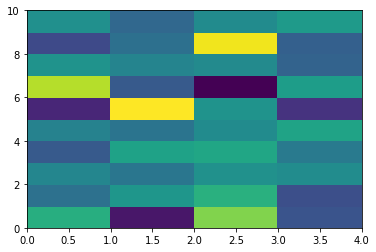

In [62]:
%%local
import seaborn as sns
%matplotlib inline

# Must redefine this variable here, since Local and Spark do not share vars
theLikesCols = ['likebroadway', 'likeclassical', 'likeconcerts', 'likejazz', 'likemusicals', 'likeopera', 'likerock', 
    'likesports', 'liketheatre', 'likevegas']
#theCorrCols = ['catVec0', 'catVec1','catVec2']
# plot the heatmap
import matplotlib.pyplot as plt
plt.pcolor(corrmat)
'''
sns.heatmap(corrmat, annot=True, fmt="g", cmap='viridis',
            yticklabels=theLikesCols)
           # xticklabels=corr.columns)
'''

You can see that, based on these ticket purchases and event attendances, the likes and event categories are only very weakly correlated (max correlation is 0.02). Though the correlations are weak, relatively speaking:
- Liking Theatre is positively correlated with Musicals
- Liking Opera is positively correlated with Plays
- Liking Rock is negatively correlated with Musicals
- Liking Broadway is negatively correlated with Plays (surprisingly!)

Now, you can move on to other analyses, such as looking at user locations vs event locations; holidays and weekends versus weekdays, and other correlations. These kinds of correlations can help understand the user base and help in developing a recommendation engine. 

Lastly, cleanup all sessions from this notebook, if you're done. (Can also be useful in case there are other sessions hanging around using up resources.)

In [28]:
%%cleanup -f